In [2]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import  silhouette_score
from kneed import KneeLocator

import matplotlib.pyplot as plt
import plotly.express as px


In [3]:
df = pd.read_csv('data/jeudi_17.csv')

In [4]:
coords = df[['Lat', 'Lon']].values


# Méthode via KMEANS

## On détermine le nombre de cluster en fonction de la méthode du coude

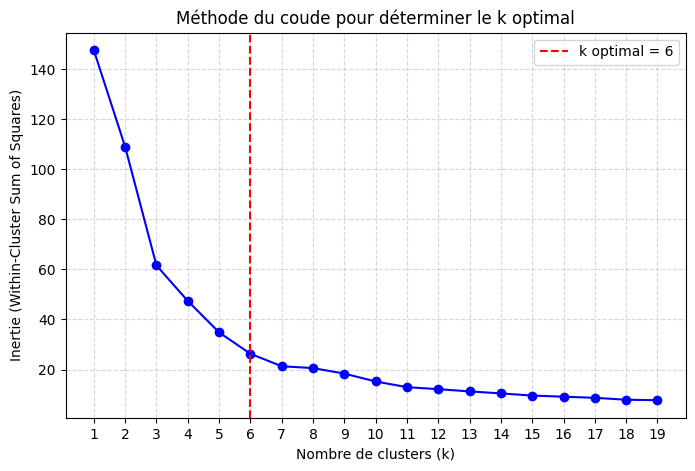

In [5]:
inertias = []
K = range(1, 20)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 'auto')
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

kneedle = KneeLocator(K, inertias, curve="convex", direction="decreasing")


plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie (Within-Cluster Sum of Squares)')
plt.title('Méthode du coude pour déterminer le k optimal')
plt.xticks(range(min(K), max(K)+1, 1))  # de min(K) à max(K), pas de 1
plt.grid(True, linestyle='--', alpha=0.5)
plt.axvline(x=kneedle.elbow, color='red', linestyle='--', label=f'k optimal = {kneedle.elbow}')
plt.legend()
plt.show()


Le coude s'effectue en k=6. 

Le nombre de cluster optimaux semble être 6.

## On va maintenant vérifier avec la silhouette

Je limite la vérification de silhouette à 10 et commence à 4 pour rester proche du k optimal via la méthode du coude

In [6]:
inertias = []
silhouette_scores = []
K = range(4, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)
    score = silhouette_score(coords, kmeans.labels_)
    silhouette_scores.append(score)



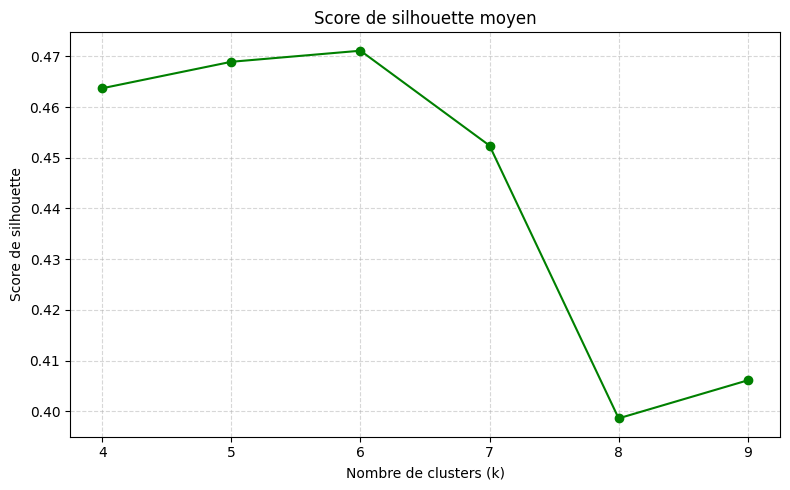

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, 'go-')
plt.title('Score de silhouette moyen')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Le nombre de cluster optimal via la méthode de la silhouette est également 6.

Pour déterminer le nombre optimal de clusters, on a utilisé deux méthodes :

La méthode du coude a permis d’observer une diminution rapide de l’inertie jusqu’à k = 5, puis une stabilisation de la courbe, suggérant un optimum autour de 6 clusters.

La méthode du score de silhouette a quantifié la cohérence des regroupements : le score moyen atteint son maximum pour k = 6 (≈ 0,47), indiquant des clusters bien séparés et homogènes.

In [8]:
kmeans = KMeans(n_clusters=6,random_state=42)
kmeans.fit(coords)

unique, counts = np.unique(kmeans.labels_, return_counts=True)
print(dict(zip(unique, counts)))

df['cluster'] = kmeans.labels_

# Vérification
df.head()


{np.int32(0): np.int64(26525), np.int32(1): np.int64(22226), np.int32(2): np.int64(2316), np.int32(3): np.int64(962), np.int32(4): np.int64(395), np.int32(5): np.int64(3994)}


,Unnamed: 0,Lat,Lon,Base,day_of_week,hour,cluster
0,3119,40.7675,-73.9666,B02512,Thursday,17,0
1,3120,40.7688,-73.8624,B02512,Thursday,17,2
2,3121,40.7356,-74.0079,B02512,Thursday,17,1
3,3122,40.6816,-73.9255,B02512,Thursday,17,5
4,3123,40.7677,-73.9826,B02512,Thursday,17,0


In [ ]:
fig = px.scatter_map(
        df,
        lat="Lat",
        lon="Lon",
        color="cluster",
        map_style="carto-positron",
        zoom=9,
        title= f"HOT POINT du jeudi à 17h"
)

fig.show()

In [10]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Lat', 'Lon'])
centers['cluster'] = range(6)
centers

,Lat,Lon,cluster
0,40.761758,-73.975114,0
1,40.730503,-73.999274,1
2,40.780598,-73.876772,2
3,40.657554,-73.785205,3
4,40.697659,-74.174525,4
5,40.688333,-73.968573,5


Selon les Latitude et Longitude, on peut déterminer que : 
 - Cluster 0 : Près de Times square / 5th avenue => Zone de bureaux ce qui correspond à la date et heure sélectionné
 - Cluster 1 : sud de Manhattan	=> Zone mixte de loisirs et restaurants → trajets de soirée, afterwork
 - Cluster 2 : LaGuardia Airport => Aéroport
 - Cluster 3 : JFK Airport	=> Aéroport
 - Cluster 4 : Newark => Zone résidentielle, Probablement des retours à domicile
 - Cluster 5 : Downtown Brooklyn / Fort Greene	=> Zone résidentielle dense, probablement des retours à domicile

# Méthode via DBSCAN

In [11]:
for eps in [0.003, 0.005, 0.008, 0.01, 0.0125]:
    db = DBSCAN(eps=eps, min_samples=200).fit(coords)
    print(f"eps={eps} → clusters: {len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)}")
    df[f'dbscan_{eps}'] = db.labels_
    unique, counts = np.unique(df[f'dbscan_{eps}'], return_counts=True)
    for u, c in zip(unique, counts):
        print(f"Cluster {u}: {c} points")


eps=0.003 → clusters: 7
Cluster -1: 9376 points
Cluster 0: 44597 points
Cluster 1: 765 points
Cluster 2: 300 points
Cluster 3: 359 points
Cluster 4: 281 points
Cluster 5: 447 points
Cluster 6: 293 points
eps=0.005 → clusters: 7
Cluster -1: 5180 points
Cluster 0: 47208 points
Cluster 1: 1221 points
Cluster 2: 748 points
Cluster 3: 311 points
Cluster 4: 813 points
Cluster 5: 627 points
Cluster 6: 310 points
eps=0.008 → clusters: 5
Cluster -1: 3279 points
Cluster 0: 49401 points
Cluster 1: 1540 points
Cluster 2: 750 points
Cluster 3: 1134 points
Cluster 4: 314 points
eps=0.01 → clusters: 4
Cluster -1: 2580 points
Cluster 0: 51227 points
Cluster 1: 1546 points
Cluster 2: 750 points
Cluster 3: 315 points
eps=0.0125 → clusters: 4
Cluster -1: 1988 points
Cluster 0: 51779 points
Cluster 1: 1581 points
Cluster 2: 752 points
Cluster 3: 318 points


Le meilleurs eps semble être 0.005 car il amène une meilleur homogénéité des groupes même si le cluster 0 surdomine les autres

In [ ]:
fig = px.scatter_map(df[df['dbscan_0.005'] != -1],lat='Lat',lon='Lon',color='dbscan_0.005',
                        zoom=10,width=1200,height=800, 
                        title='DBSCAN clusters in NYC')
fig.show()

In [14]:
df_clusters = df[df['dbscan_0.005'] != -1]

centers = df_clusters.groupby('dbscan_0.005')[['Lat', 'Lon']].mean().reset_index()

print(centers)

   dbscan_0.005        Lat        Lon
0             0  40.746626 -73.986732
1             1  40.771314 -73.867529
2             2  40.644826 -73.784738
3             3  40.772763 -73.885746
4             4  40.696396 -73.989507
5             5  40.716764 -73.959653
6             6  40.691661 -74.179581


Les centroïdes DBSCAN révèlent 7 pôles d’activité majeurs Uber à New York, correspondant à :

 - 3 pôles de transport (JFK, LaGuardia, Newark),

 - 1 pôle central (Midtown Manhattan),

 - 3 pôles secondaires (Brooklyn / Queens ) associés à des flux pendulaires et de loisirs.

Les principaux noeuds d'activité sont identique. Afin de faciliter l'automatisation, je vais utiliser la méthode DBSCAN pour l'étude par jour.